<a href="https://colab.research.google.com/github/UTakeuchi/PDsimulator/blob/main/main_case2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Q学習エージェント

In [2]:
def greedy_probs(Q, state, epsilon=0, action_size=2):
    qs = [Q[state][action] for action in range(action_size)]
    max_action = np.argmax(qs)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

In [3]:
class Agent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 2   

        random_actions = {0: 0.5, 1: 0.5}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        init = {0: 0, 1: 0}
        self.Q = defaultdict(lambda: init)
    
    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def update(self, state, action, reward, next_state):
        next_qs = [self.Q[next_state][a] for a in range(self.action_size)]
        next_q_max = max(next_qs)
        
        target = reward + self.gamma * next_q_max
        self.Q[state][action] += self.alpha * (target - self.Q[state][action])

        self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)

# Prisoner's dillema game

In [4]:
class PDGame:
    def __init__(self):
        self.action_space = [0, 1]
        self.action_meaning = {
            0: "Defect",
            1: "Cooperate",
        }
        self.b = 5 #benefit
        self.c = 1 #cost
    
    def matching(self, agents):
        pairs = len(agents) // 2
        return np.random.choice(agents, size=(pairs, 2), replace=False) # agentの番号を返す
        
    def step(self, a1, a2):
        u1 = {(1, 1):self.b - self.c, (1, 0):-self.c, (0, 1):self.b, (0, 0):0}
        u2 = {(1, 1):self.b - self.c, (1, 0):self.b, (0, 1):-self.c, (0, 0):0}
        return u1[(a1,a2)], u2[(a1,a2)]

# シミュレーションの実行

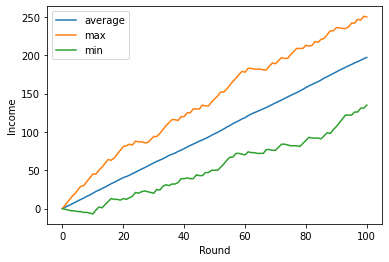

In [5]:
env = PDGame()
n = 100 # agentの人数 n
agents = []
for i in range(n):
    agents.append(Agent())
incomes = np.zeros(n) # 所得はAgents()の外部に格納
income_history = np.zeros((3,1)) # 各行に平均値・最大値・最小値の推移を格納

rounds = 100
for round in range(rounds):
    players = env.matching(range(len(agents)))
    for pair in players:
        x, y = pair
        player1, player2 = agents[x], agents[y]
        state = (incomes[x], incomes[y]) #stateは（自分の所得, 相手の所得）の順にする
    
        a1 = player1.get_action(state)
        a2 = player2.get_action(state[::-1]) #player2目線に変換
        r1, r2 = env.step(a1, a2)
        incomes[x] += r1
        incomes[y] += r2
        next_state = (incomes[x], incomes[y])
        player1.update(state, a1, r1, next_state)
        player2.update(state[::-1], a2, r2, next_state[::-1])

    add = np.array([[np.mean(incomes)], [incomes.max()], [incomes.min()]])
    income_history = np.append(income_history, add, axis=1)

# rand = np.random.randint(0, n)
# for i in range(n):
#     if i == rand:
#         print("----------agent{}'s policy-----------".format(i+1))
#         for key, value in agents[i].pi.items():
#             print('state:{}, policy:{}'.format(key, value))
#         print('policy number = ' + str(len(agents[i].pi)))

def plot_total_income(history):
    plt.xlabel('Round')
    plt.ylabel('Income')
    plt.plot(range(len(history[0])), history[0], label='average')
    plt.plot(range(len(history[1])), history[1], label='max')
    plt.plot(range(len(history[2])), history[2], label='min')
    plt.legend()
    plt.show()

plot_total_income(income_history)
# print(incomes)
# income_history
# agents[0].Q